# Solution of a simple truss in SolidsPy

Let's find the displacements for a simple truss made with three bars forming
a triangle with angles 30°, 60° and 90°.

In [1]:
#pip install solidspy

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol
import solidspy.uelutil as uel

In [3]:
#% matplotlib notebook


## Input

The problem of interest is represented in the following image,

<center><img src="img/simple_truss.svg" alt="Problem of interes" style="width:400px"></center>

the section of each bar is $A = \frac{1}{100}\text{ m}^2$ and the Young
modulus $E = 10^6\text{ Pa}$.

### Nodes

First, let's define the nodes array for this problem. Each row is of the form

    node_id coord_x coord_y cons_x cons_y
    
where:

- ``node_id``: is the node identifier;
- ``coord_x``: is the $x$ coordinate of the node;
- ``coord_y``: is the $y$ coordinate of the node;
- ``cons_x``: tells us if the node is constrained in the $x$ direction;
- ``cons_y``: tells us if the node is constrained in $y$;

-1 means constrained and 0 unconstrained.

In [4]:
nodes = np.array([
    [0, 5.0, 0.0, 0, 0],
    [1, 0.0, 10*np.sqrt(3)/2, -1, 0],
    [2, 0.0, 0.0, -1, -1]])

### Materials

Now, let's define the "materials" array, in this array we put the information
related to thickness and Young modulus for each bar. Each element can have
different values. The form for each row is

    young area

with:

- ``young``: Young modulus of the bar.
- ``area``: cross-sectional area of the bar;

In [5]:
mats = np.array([
    [1e6, 0.01],
    [1e6, 0.01],
    [1e6, 0.01]])

### Elements

The elements array provide the connectivity between nodes, material profile,
and type of element for each element. The form for each row is

    el_id el_type mat_profile node_ini node_end

where:

- ``el_id``: element identifier;
- ``el_type``: element type (6 for truss elements);
- ``mat_profile``: material profile, in this case we have one material profile
  for each element;
- ``node_ini``: first node of the bar;
- ``node_end``: last node of the bar.

In [6]:
eles = np.array([
    [0, 6, 0, 2, 0],
    [1, 6, 1, 0, 1],
    [2, 6, 2, 1, 2]])

### Loads

The loads array should have the number of node and the components
of the forms, in the following form

    node_id force_x force_y

In [7]:
loads = np.array([
    [0, 0.0, -20.0],
    [1, 0.0, 0.0]])

Now, let's plot a graphic of the truss given by our arrays to double-check.

In [8]:
def plot_truss(nodes, elements, mats, color="green"):
    """
    Plot a truss
    """
    areas = mats[:, 1]
    min_area = areas.min()
    max_area = areas.max()
    max_val = 4
    min_val = 0.5
    if max_area - min_area > 1e-6:
        widths = (max_val - min_val)*(areas - min_area)/(max_area - min_area)\
            + min_val
    else:
        widths = 3*np.ones_like(areas)
    for el in elements:
        ini, end = el[3:]
        plt.plot([nodes[ini, 1], nodes[end, 1]],
                [nodes[ini, 2], nodes[end, 2]],
                color=color, lw=widths[el[2]])
    plt.axis("image")

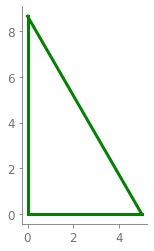

In [9]:
plt.figure()
plot_truss(nodes, eles, mats, color="green");

## Elemental matrices

The first step to solve the problem is to compute the stiffness matrices
for each member of the truss in global coordinates. These matrices
are given by

$$K_0 = \frac{2000}{\sqrt{3}}\begin{bmatrix}
1 &0 &-1 &0\\
0 &0 &0 &0\\
1 &0 &-1 &0\\
0 &0 &0 &0\end{bmatrix}$$

$$K_1 = 250\begin{bmatrix}
3 &-\sqrt{3} &-3 &\sqrt{3}\\
\sqrt{3} &1 &\sqrt{3} &-1\\
-3 &\sqrt{3} &3 &-\sqrt{3}\\
\sqrt{3} &-1 &-\sqrt{3} &1\end{bmatrix}$$

$$K_2 = 2000\begin{bmatrix}
0 &0 &0 &0\\
0 &1 &0 &1\\
0 &0 &0 &0\\
0 &-1 &0 &1\end{bmatrix}$$

We can double-check that this result is correct printing the matrices
returned by ``uel.ueltruss2D`` from ``solidspy``.

In [10]:
for cont in range(3):
    Kloc = uel.ueltruss2D(nodes[eles[cont, 3:], 1:3], *mats[cont, :])
    print("Element {}\n".format(cont), np.round(Kloc))

Element 0
 [[ 2000.     0. -2000.     0.]
 [    0.     0.     0.     0.]
 [-2000.     0.  2000.     0.]
 [    0.     0.     0.     0.]]
Element 1
 [[ 250. -433. -250.  433.]
 [-433.  750.  433. -750.]
 [-250.  433.  250. -433.]
 [ 433. -750. -433.  750.]]
Element 2
 [[    0.     0.     0.     0.]
 [    0.  1155.     0. -1155.]
 [    0.     0.     0.     0.]
 [    0. -1155.     0.  1155.]]


## System assembly

Once we have the elemental matrices we can form the global system of
equations to obtain the global matrix.

### Unconstrained matrix

Let's consider, for now, that none of the nodes is contrained. From a
physics point of view, that might be unsound, since that would render
the problem undetermined. We will solve that problem later on.

The global matrix (for unconstrained nodes) is

$$K_\text{total} = 250 \begin{bmatrix}
\frac{8}{\sqrt{3}} + 3 &-\sqrt{3} &3 &\sqrt{3} &-\frac{8}{\sqrt{3}} &0\\
-\sqrt{3} &1 &\sqrt{3} &-1 &0 &0\\
3 &\sqrt{3} &3 &-\sqrt{3} &0 &0\\
\sqrt{3} &-1 &-\sqrt{3} &9 &0 &-8\\
-\frac{8}{\sqrt{3}} &0 &0 &0 &\frac{8}{\sqrt{3}} &0\\
0 &0 &0 &-8 &0 &8
\end{bmatrix}$$

To check that step we can use the ``solidspy`` as well, considering a different
nodes array.

In [11]:
nodes_uncon = np.array([
    [0, 5.0, 0.0, 0, 0],
    [1, 0.0, 10*np.sqrt(3)/2, 0, 0],
    [2, 0.0, 0.0, 0, 0]])
DME , IBC , neq = ass.DME(nodes_uncon, eles)
KG_uncon = ass.assembler(eles, mats, nodes_uncon, neq, DME, sparse=False)
print(np.round(KG_uncon))

[[ 2250.  -433.  -250.   433. -2000.     0.]
 [ -433.   750.   433.  -750.     0.     0.]
 [ -250.   433.   250.  -433.     0.     0.]
 [  433.  -750.  -433.  1905.     0. -1155.]
 [-2000.     0.     0.     0.  2000.     0.]
 [    0.     0.     0. -1155.     0.  1155.]]


### Constrained matrix

In our problem, we are interested in the constrained stiffness matrix.
First, because the underlying system of equations has a unique solution.
Second, because that would make it smaller.

The constrained matrix is the following

$$K_\text{total}^\text{cons} = 250 \begin{bmatrix}
\frac{8}{\sqrt{3}} + 3 &-\sqrt{3} &\sqrt{3}\\
-\sqrt{3} &1  &-1 \\
\sqrt{3} &-1 &9\\
\end{bmatrix}$$

We can check that result with ``solidspy`` as well.

In [12]:
# System assembly
DME , IBC , neq = ass.DME(nodes, eles)
stiff = ass.assembler(eles, mats, nodes, neq, DME, sparse=False)
load_vec = ass.loadasem(loads, IBC, neq) # right-hand-side

In [13]:
print(np.round(stiff))

[[2250. -433.  433.]
 [-433.  750. -750.]
 [ 433. -750. 1905.]]


In [14]:
print(load_vec)

[  0. -20.   0.]


In [15]:
# System solution
disp = sol.static_sol(stiff, load_vec)
disp

array([-0.0057735 , -0.04732051, -0.01732051])

In [16]:
# Post-processing
disp_complete = pos.complete_disp(IBC, nodes, disp)
disp_complete

array([[-0.0057735 , -0.04732051],
       [ 0.        , -0.01732051],
       [ 0.        ,  0.        ]])

In [17]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()